In [18]:
import fiona
import rasterio
from rasterio.mask import mask

from osgeo import gdal

import os
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from keras.metrics import MeanIoU

In [3]:
os.getcwd()

'/data/private/Thesis/May'

#### **Crop with gdal**

In [108]:
label = gdal.Open('Data/01_Preprocessed/label_bin.tif')
pred = gdal.Open('Output/pred_s1_5e-6.tif')

label = gdal.Warp("label_clip.tif", label, cutlineDSName = "Data/04_Validation/Testing_extent2.shp",
                  cropToCutline = True, dstNodata = np.nan)

label = label.GetRasterBand(1).ReadAsArray()

pred = gdal.Warp("pred_clip.tif", pred, cutlineDSName = "Data/04_Validation/Testing_extent2.shp",
                  cropToCutline = True, dstNodata = np.nan)

pred = pred.GetRasterBand(1).ReadAsArray()

Warning 1: for band 1, destination nodata value has been rounded to 0, Byte being an integer datatype.


#### **Fionna**

In [4]:
with fiona.open('Data/04_Validation/Testing_extent.shp', 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

In [10]:
with rasterio.open("Data/01_Preprocessed/label_bin.tif") as src:
    label, label_transform = mask(src, shapes, crop=True)
    label_meta = src.meta

label_meta.update({
    "driver": 'Gtiff',
    "height": label.shape[1],
    "width": label.shape[2],
    "transform": label_transform
})

with rasterio.open("Output/pred_s1_1e-6.tif") as src:
    pred, pred_transform = mask(src, shapes, crop=True)
    pred_meta = src.meta

pred_meta.update({
    "driver": 'Gtiff',
    "height": pred.shape[1],
    "width": pred.shape[2],
    "transform": pred_transform
})

#### **Visualize**

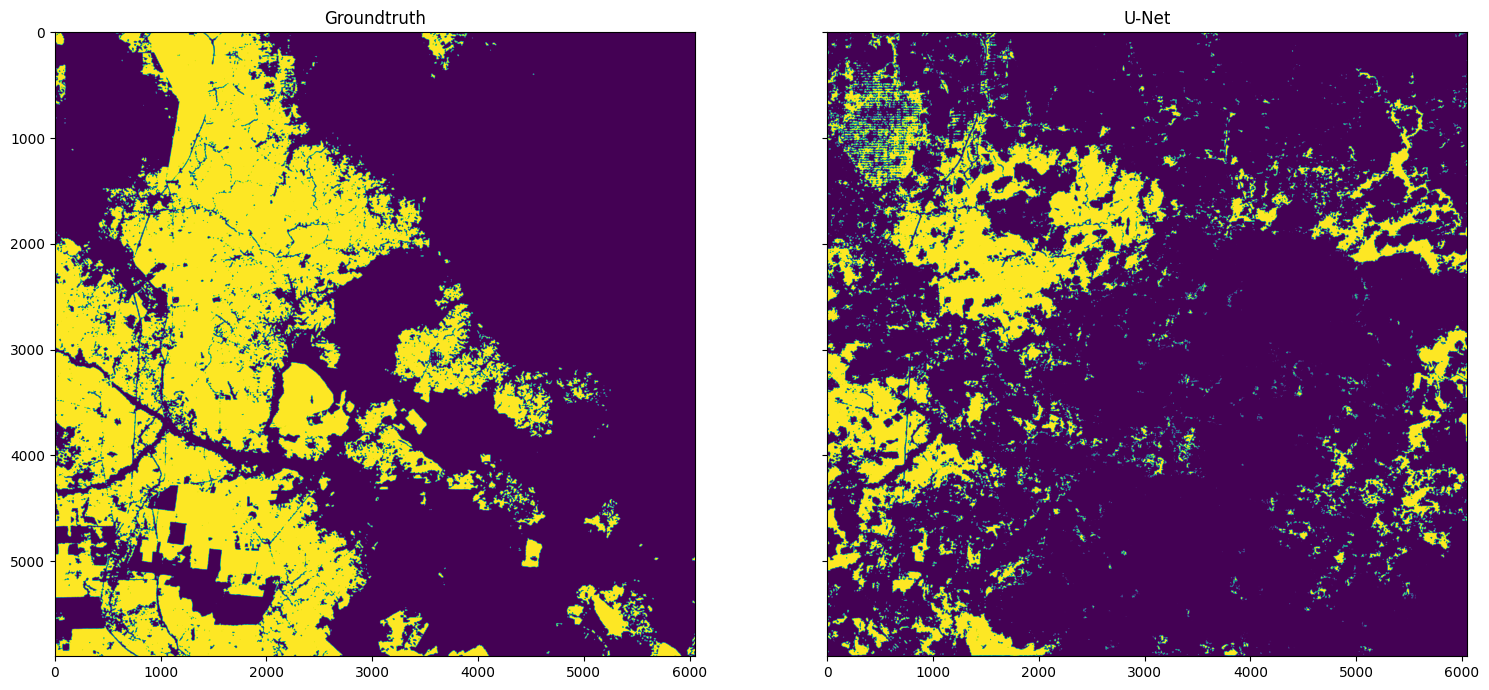

In [71]:
#Plot
import earthpy.plot as ep

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharey=True)

axs[0].imshow(label)
axs[0].set_title("Groundtruth")
axs[1].imshow(pred)
axs[1].set_title("U-Net")

plt.tight_layout()
plt.show()

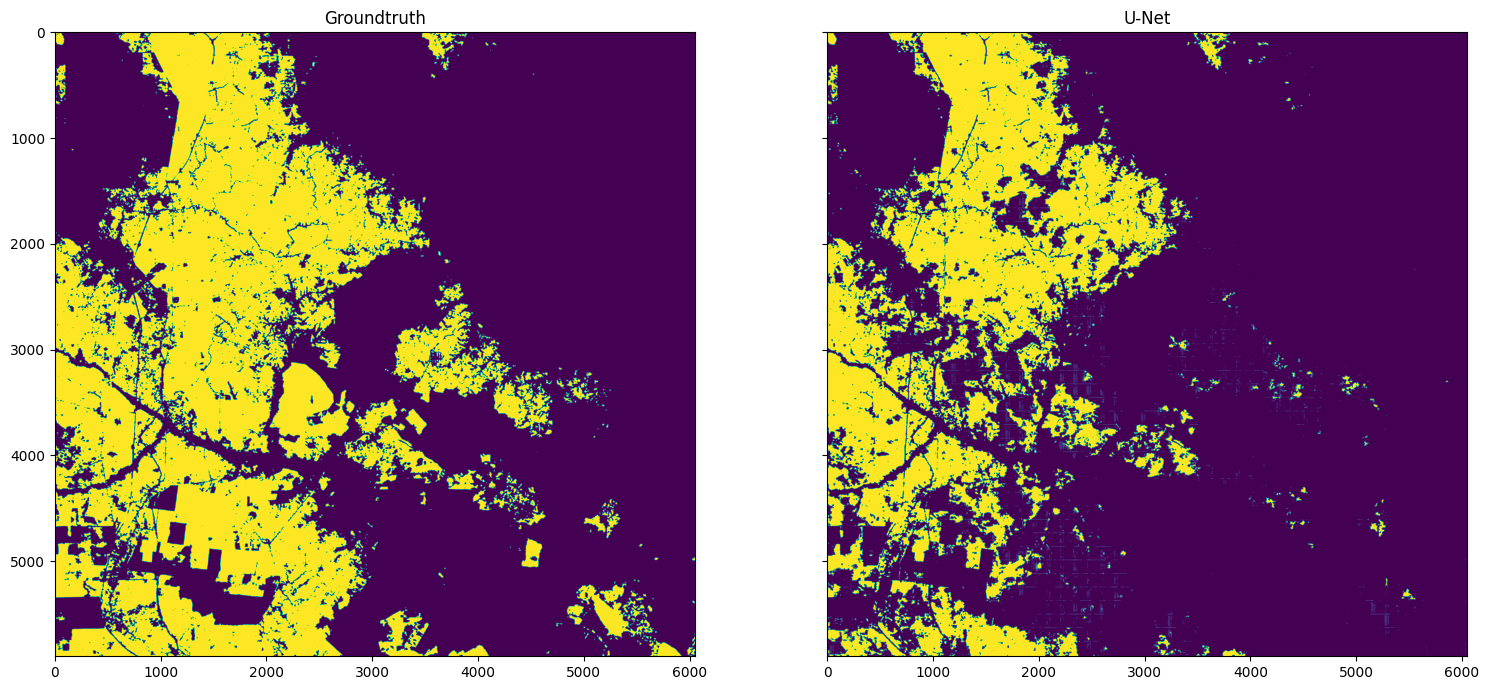

In [79]:
#Plot
import earthpy.plot as ep

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharey=True)

axs[0].imshow(label)
axs[0].set_title("Groundtruth")
axs[1].imshow(pred)
axs[1].set_title("U-Net")

plt.tight_layout()
plt.show()

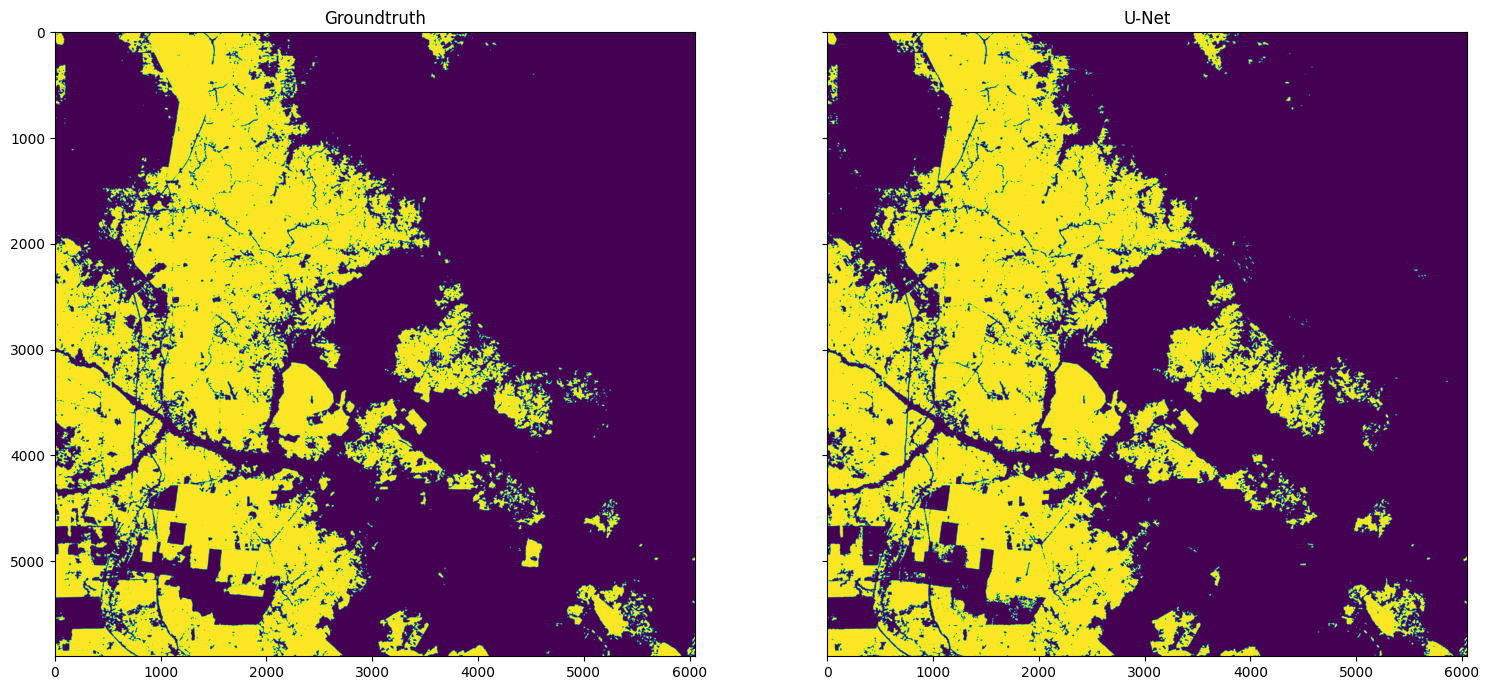

In [87]:
#Plot
import earthpy.plot as ep

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharey=True)

axs[0].imshow(label)
axs[0].set_title("Groundtruth")
axs[1].imshow(pred)
axs[1].set_title("U-Net")

plt.tight_layout()
plt.show()

#### **Accuracy assessment**

##### **IoU**

In [109]:
classes = np.unique(label)
print(classes)

n_classes = int(max(classes)) + 1
print(n_classes)

[0. 1.]
2


In [110]:
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(label, pred)
print("Mean IoU2 = ", IOU_keras.result().numpy())

Mean IoU2 =  0.9027397


##### **Confusion matrix**

In [111]:
label = label.flatten()
pred = pred.flatten()

In [112]:
cfm = confusion_matrix(label, pred)

In [113]:
import pandas as pd

df = pd.DataFrame(cfm, columns=['NOP', 'OP'], index=['NOP', 'OP'])
df

,NOP,OP
NOP,22275381,1102507
OP,402098,11903065


In [114]:
from sklearn.metrics import classification_report

print('Train report', classification_report(label, pred))

Train report               precision    recall  f1-score   support

         0.0       0.98      0.95      0.97  23377888
         1.0       0.92      0.97      0.94  12305163

    accuracy                           0.96  35683051
   macro avg       0.95      0.96      0.95  35683051
weighted avg       0.96      0.96      0.96  35683051

